# Table

In [1]:
import geopandas as gpd

directory = '/Users/arthurcalvi/Data/results/disturbances/matching_france_v02_EPSG3857.parquet'
gdf = gpd.read_parquet(directory)


# Research

In [76]:
import json 

def get_nd(item, daoi, geometry):
    if dplatform[ item.properties['platform'] ] == 'landsat-7':
        _, nd = get_cc(item, geometry, daoi, config)
        item.properties.setdefault('nodata', nd)
    return None

def is_pan_available(item, geometry):
    sat = dplatform[item.properties['platform']]
    try : 
        collection = config[sat]['pan']['collection']
        item_pan = collection.get_item( item.id.replace(config[sat]['pan']['from'], config[sat]['pan']['to']) )
        metadata = json.loads(item_pan.assets.download_as_str('MTL_JSON'))
        pan = item_pan.assets.crop_as_array(config[sat]['pan']['pan_band'], bbox= shape(geometry).bounds)
        return True
    except : 
        return False
    
def get_res(item, geometry):
    sat = dplatform[item.properties['platform']]
    band = config[sat]['rgb_bands'][0]
    res = config[sat]['resolution'][band]
    if 'pan' in config[sat].keys() and is_pan_available(item, geometry):
        res = config[sat]['resolution']['pan']
    item.properties['resolution'] = res

In [108]:
%load_ext autoreload
%autoreload 2

from chronos import research_items, get_sats, priority, config, dplatform, check_intervals, get_cc
import pandas as pd
import numpy as np 
from shapely.geometry import shape
from rasterio.features import rasterize
from rasterio.warp import transform_geom
from copy import deepcopy
from datetime import datetime, timezone
from joblib import Parallel, delayed

verbose=1
index = 100
buffer = 3000 #meters
delta_min = 15 #days
cc1 = 3
cc2 = 75
start_date = datetime(2010, 1, 1, 10, 10, 10, tzinfo=timezone.utc)
end_date = datetime(2016, 12, 31, 10, 10, 10, tzinfo=timezone.utc)
geometry = gdf.iloc[index]['geometry']

#geometry
old_geometry = deepcopy(geometry)
geometry = transform_geom('epsg:3857', 'epsg:4326', shape(old_geometry).convex_hull)
geometry_buffer = transform_geom('epsg:3857', 'epsg:4326', shape(old_geometry).convex_hull.buffer(buffer))

#sats 
count_sat = {}
sats = get_sats(start_date, end_date, config, priority)
if verbose > 0:
    print(sats)
for sat in sats:
    count_sat[sat] = 0

#RESEARCH 1
items1 = research_items(geometry, start_date, end_date, sats, config, cc1)

#retrieve crs, transform and array for each sat

items1_sat = set([dplatform[item.properties['platform']] for item in items1])
items1_prop = {sat:None for sat in items1_sat}
for sat in items1_sat:
    i = 0 
    temp_items1 = [item for item in items1 if dplatform[item.properties['platform']] == sat]
    while items1_prop[sat] is None and i < len(temp_items1):
        item = temp_items1[i]
        try :
            crs, transfo, arr, _ = item.assets.crop_as_array(config[ dplatform[ item.properties['platform'] ] ]['qa'][0], bbox= shape(geometry).bounds)
            items1_prop[sat] = {'crs':crs, 'transfo':transfo, 'arr':arr}
        except :
            pass
        i += 1

items1_sat = [sat for sat in items1_sat if items1_prop[sat] is not None]
#retrieve aoi for each sat
daoi = {}
for sat in items1_sat:
    daoi[sat] = rasterize([transform_geom('epsg:3857', items1_prop[sat]['crs'] , old_geometry.buffer(100).convex_hull)], out_shape = items1_prop[sat]['arr'].shape[1:], transform=items1_prop[sat]['transfo'], fill=np.nan, all_touched=False)

#research and filter for landsat-7
_ = Parallel(n_jobs=-1, prefer='threads', verbose=verbose)(delayed(get_nd)(item, daoi, geometry) for item in items1)
items1 = [item for item in items1 if ('nodata' not in item.properties or item.properties['nodata'] <= 25)]

if verbose > 0:
            print(f'Items found for research 1 with cc={cc1} : {len(items1)}')
x = [start_date] + [item.properties['datetime'] for item in items1] + [end_date]
y = [None] + [sats.index( dplatform[ item.properties['platform'] ]) for item in items1] + [None]

#gap
df = pd.DataFrame(data=np.array([x,y]).T, columns=['date', 'sat'])
df['gap'] = (df.date - df.date.shift()).dt.days
df['hole'] = (df.gap > delta_min)
dates_hole = [[df.date.iloc[x-1], df.date.iloc[x]] for x in df.index.to_numpy()[df.hole]]

#RESEARCH 2 
items2 = research_items(geometry, start_date, end_date, sats, config, cc2)
dates = [item.properties['datetime'] for item in items2]
indexes_prob = [check_intervals(date, dates_hole, 1) for date in dates]
items_prob = [items2[i] for i in range(len(items2)) if indexes_prob[i]]


#retrieve crs, transform and array for each sat 
items2_sat = set([dplatform[item.properties['platform']] for item in items2])
items2_prop = items1_prop
if not sorted(items2_sat) == sorted(items1_sat):
    for sat in items2_sat:
        if sat not in items1_sat:
            count_sat[sat] = 0
            i = 0 
            temp_items2 = [item for item in items2 if dplatform[item.properties['platform']] == sat]
            while items2_prop[sat] is None and i < len(temp_items2):
                item = temp_items2[i]
                try :
                    crs, transfo, arr, _ = item.assets.crop_as_array(config[ dplatform[ item.properties['platform'] ] ]['qa'][0], bbox= shape(geometry).bounds)
                    items2_prop[sat] = {'crs':crs, 'transfo':transfo, 'arr':arr}
                except :
                    pass
                i += 1

items2 = [item for item in items2 if items2_prop[dplatform[item.properties['platform']]] is not None]
items2_sat = [sat for sat in items2_sat if items2_prop[sat] is not None]

if len(items2) > 0:
    daoi = {}
    for sat in items2_sat:
        daoi[sat] = rasterize([transform_geom('epsg:3857', items2_prop[sat]['crs'] , old_geometry.buffer(100).convex_hull)], out_shape = items2_prop[sat]['arr'].shape[1:], transform=items2_prop[sat]['transfo'], fill=np.nan, all_touched=False)
    cc_nodata = Parallel(n_jobs=-1, prefer='threads', verbose=verbose)(delayed(get_cc)(item, geometry, daoi, config) for item in items_prob)
    indexes_cc_ok = (np.array(cc_nodata)[:,0] < 25)
    indexes_nodata_ok = (np.array(cc_nodata)[:,1] < 25)
    cloud_cover = np.array(cc_nodata)[indexes_cc_ok, 0]
    nodata_cover = np.array(cc_nodata)[indexes_nodata_ok, 1]
    items_ok = [items_prob[i] for i in range(len(items_prob)) if (indexes_cc_ok[i] and indexes_nodata_ok[i])]

    #update CC:
    for i,item in enumerate(items_ok):
        item.properties['eo:cloud_cover'] = cloud_cover[i]
        item.properties['nodata'] = nodata_cover[i]

    if verbose > 0:
        print(f'Items found for research 2 with cc=25 (on aoi) : {len(items2)}')

    #assembling
    items1.extend(items_ok)
    items1 = sorted(items1, key=lambda x:x.properties['datetime'])
    _ = Parallel(n_jobs=-1, prefer='threads', verbose=verbose)(delayed(get_res)(item, geometry) for item in items1)
    if verbose > 0:
        print('Items found for combined research: ', len(items1))

    #filtering
    x = [item.properties['datetime'] for item in items1]
    cc = [item.properties['eo:cloud_cover'] for item in items1]
    nd = [item.properties.get('nodata', np.nan) for item in items1]
    res = [item.properties['resolution'] for item in items1]

    y = [sats.index(dplatform[ item.properties['platform'] ]) for item in items1]
    df = pd.DataFrame(data=np.array([x,y,cc,nd, res]).T, columns=['date', 'sat', 'cc', 'nodata', 'resolution'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['landsat-5', 'landsat-7', 'landsat-8']


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:    8.5s finished


Items found for research 1 with cc=3 : 28


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   57.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Items found for research 2 with cc=25 (on aoi) : 262


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s


Items found for combined research:  128


[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:   36.7s finished


# Date selection

In [105]:
import statistics
import math
import matplotlib.pyplot as plt

def get_scores(graph, nodes, cc_ub, sr_ub, nd_ub):
    #score 
    attribute1_list = [graph.nodes[n]['cloud_cover'] for n in nodes]
    attribute2_list = [graph.nodes[n]['spatial_res'] for n in nodes]
    attribute3_list = [graph.nodes[n]['nodata'] for n in nodes]
    return [1/cc_ub * x + 1/sr_ub * y + 1/nd_ub * z for x, y, z in zip(attribute1_list, attribute2_list, attribute3_list)], (attribute1_list, attribute2_list, attribute3_list)

def get_metrics(graph, shortest_path, cc_ub=10, sr_ub=30, nd_ub=25):
    """_summary_
    
    Args:
        graph (_type_): _description_
        shortest_path (_type_): _description_
        a (int, optional): _description_. Defaults to 1.
        b (int, optional): _description_. Defaults to 1.
        c (int, optional): _description_. Defaults to 1.

    Returns:
        _type_: _description_
    """

    #score 
    scores, (attribute1_list, attribute2_list, attribute3_list) = get_scores(graph, shortest_path, cc_ub, sr_ub, nd_ub)
    avg_score = statistics.mean(scores)
    avg_cloud_cover = statistics.mean(attribute1_list)
    avg_spatial_res = statistics.mean(attribute2_list)
    avg_nodata = statistics.mean(attribute3_list)

    #weight
    weights = [graph.edges[n]['weight'] for n in zip(shortest_path, shortest_path[1:])]
    avg_weight = statistics.mean(weights)
    std_dev_weight = statistics.stdev(weights)

    return avg_score, avg_cloud_cover, avg_spatial_res, avg_nodata, avg_weight, std_dev_weight

def weight_function(u, v, graph, target_weight):
        # Calculate the weight based on the difference between the actual weight and the target weight
        actual_weight = graph[u][v]['weight']
        weight_diff = abs(actual_weight - target_weight)
        return weight_diff

def select_dates(df, target_weight=30, lower_bound=20, verbose=0, cc_ub=10, sr_ub=30, nd_ub=25):

    df = df.fillna(0)
    timestamps = (df['date'] - df['date'].min() ).dt.days.to_numpy()


    #build timestamp difference matrix (adjencty matrix)
    N = len(timestamps)
    x = np.ones(N)
    deltaT = np.outer(x, timestamps) - np.outer(timestamps, x)
    ub = (df['date'] - df['date'].shift() ).dt.days.max() * 1.25

    if verbose > 0:
        print('upper bound : ', ub)
    deltaT_cond = deltaT.copy()
    deltaT_cond[ (abs(deltaT) > ub) | (abs(deltaT) < lower_bound) ] = np.nan
    deltaT_cond[ deltaT < 0 ] = np.nan

    if verbose > 1:
        plt.figure(figsize=(10, 10))
        plt.title('adjency matrix')
        plt.imshow(deltaT_cond)
        plt.colorbar(shrink=0.6, label='difference in days')
        plt.xlabel('nodes')
        plt.ylabel('nodes')
        plt.show()

    #build graph
    # Create an empty graph
    graph = nx.DiGraph()

    # Add nodes to the graph
    for i in range(len(timestamps)):
        row = df.iloc[i]
        attributes = {
            'cloud_cover': row['cc'],
            'spatial_res': row['resolution'],
            'nodata' : row['nodata'], 
            'date' : timestamps[i]
        }
        graph.add_node(i, **attributes)

    # Add edges to the graph based on the time differences
    for i in range(len(timestamps)):
        for j in range(i+1, len(timestamps)):
            time_diff = deltaT_cond[i][j]
            
            if lower_bound < time_diff < ub:
                if i < j:
                    graph.add_edge(i, j, weight = time_diff)
                else:
                    graph.add_edge(j, i, weight = time_diff)

    if verbose > 0:
        print('is strongly connected : ', nx.is_strongly_connected(graph))
        print('is weakly connected : ', nx.is_weakly_connected(graph))

    # Find the path that minimizes the sum of scores while considering weights with approximately the same weight
    start_node = 0
    end_node = len(timestamps) - 1
    shortest_path = None
    min_score = (math.inf, math.inf)
    buffer = 15 #days

    # Iterate over possible start and end nodes within the buffer time period
    for i in range(0, 10):
        start_date = graph.nodes[start_node]['date']
        possible_start = graph.nodes[i]
        possible_start_date = possible_start['date']
        time_diff_start = abs(possible_start_date - start_date)

        if time_diff_start <= buffer:
            for j in range(len(timestamps) - 10, len(timestamps)):
                end_date = graph.nodes[end_node]['date']
                possible_end = graph.nodes[j]
                possible_end_date = possible_end['date']
                time_diff_end = abs(possible_end_date - end_date)

                if time_diff_end <= buffer:
                    path = nx.shortest_path(graph, i, j, weight=lambda u, v, d: weight_function(u, v, graph, target_weight))

                    if path is not None:
                        #compute metrics
                        avg_score, avg_cloud_cover, avg_spatial_res, avg_nodata, avg_weight, std_dev_weight = get_metrics(graph, path)
                        tmp_score = (avg_score, abs(target_weight - avg_weight))
                        if tmp_score < min_score:
                            min_score = tmp_score
                            shortest_path = path
                            print(f'Avg Score: {avg_score:.2f}, Avg Cloud cover: {avg_cloud_cover:.2f}, Avg Spatial res: {avg_spatial_res:.2f}, Avg nodata: {avg_nodata:.2f}, Avg Weight: {avg_weight:.2f}, Std Dev Weight: {std_dev_weight:.2f}')

    # Create a scatter plot of nodes
    scores, _  = get_scores(graph, graph.nodes(), cc_ub=cc_ub, sr_ub=sr_ub, nd_ub=nd_ub)
    x = [graph.nodes[n]['date'] for n in graph.nodes()]

    if verbose > 1:
        plt.figure(figsize=(20, 10))
        plt.scatter(x, scores, s=15, color='green', alpha=0.5)
        plt.title('Graph Visualization')
        plt.xlabel('Time')
        plt.ylabel('Score')

        # Add arrows to the plot for the shortest path
        for i in range(len(shortest_path) - 1):
            u = shortest_path[i]
            v = shortest_path[i+1]
            plt.arrow(x[u], scores[u], x[v] - x[u], scores[v] - scores[u], color='red', alpha=0.5, width=0.01, head_width=0.01, length_includes_head=True, linestyle='solid')

        scores_s, _ = get_scores(graph, shortest_path, cc_ub=10, sr_ub=30, nd_ub=25)
        plt.scatter([graph.nodes[n]['date'] for n in shortest_path], scores_s, marker='x', color='red')
        #compute metrics
        avg_score, average_attribute1, average_attribute2, average_attribute3, average_weight, std_dev_weight = get_metrics(graph, shortest_path)

        # Add arrows to the plot for directed edges
        plt.text(0.05, 0.75, f'Average Cloud cover: {average_attribute1:.2f}', transform=plt.gca().transAxes)
        plt.text(0.05, 0.7, f'Average Spatial res: {average_attribute2:.2f}', transform=plt.gca().transAxes)
        plt.text(0.05, 0.65, f'Average nodata: {average_attribute3:.2f}', transform=plt.gca().transAxes)

        plt.text(0.05, 0.9, f'Avg Score: {avg_score:.2f}', transform=plt.gca().transAxes)

        plt.text(0.05, 0.85, f'Average Weight: {average_weight:.2f}', transform=plt.gca().transAxes)
        plt.text(0.05, 0.8, f'Std Dev Weight: {std_dev_weight:.2f}', transform=plt.gca().transAxes)
        plt.show()

    selectionned_dates = np.zeros(N)
    selectionned_dates[shortest_path] = 1
    df['selected'] = selectionned_dates
    return df
    
  

upper bound :  270.0


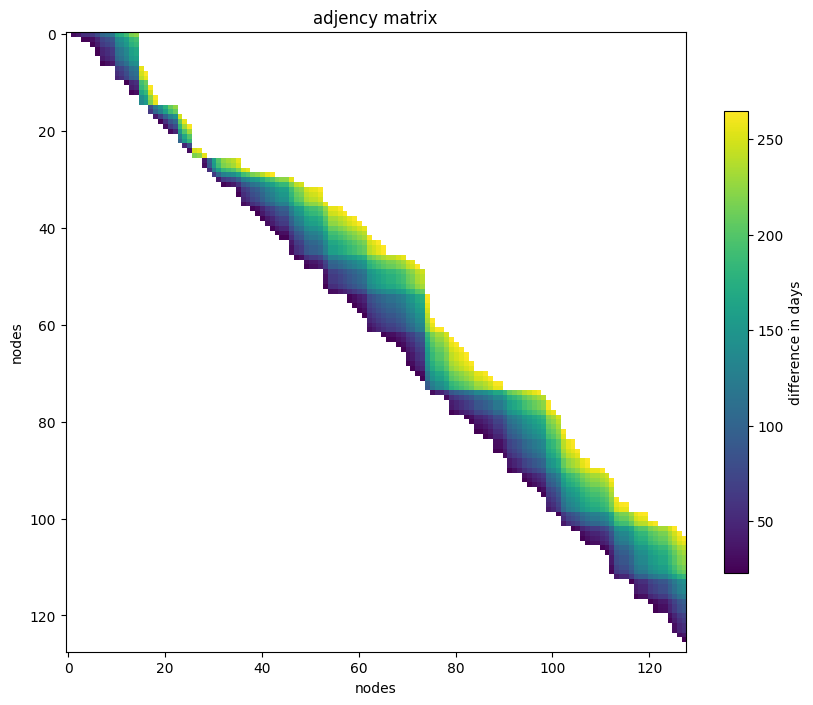

is strongly connected :  False
is weakly connected :  True
Avg Score: 0.77, Avg Cloud cover: 1.01, Avg Spatial res: 18.00, Avg nodata: 1.56, Avg Weight: 40.80, Std Dev Weight: 31.18


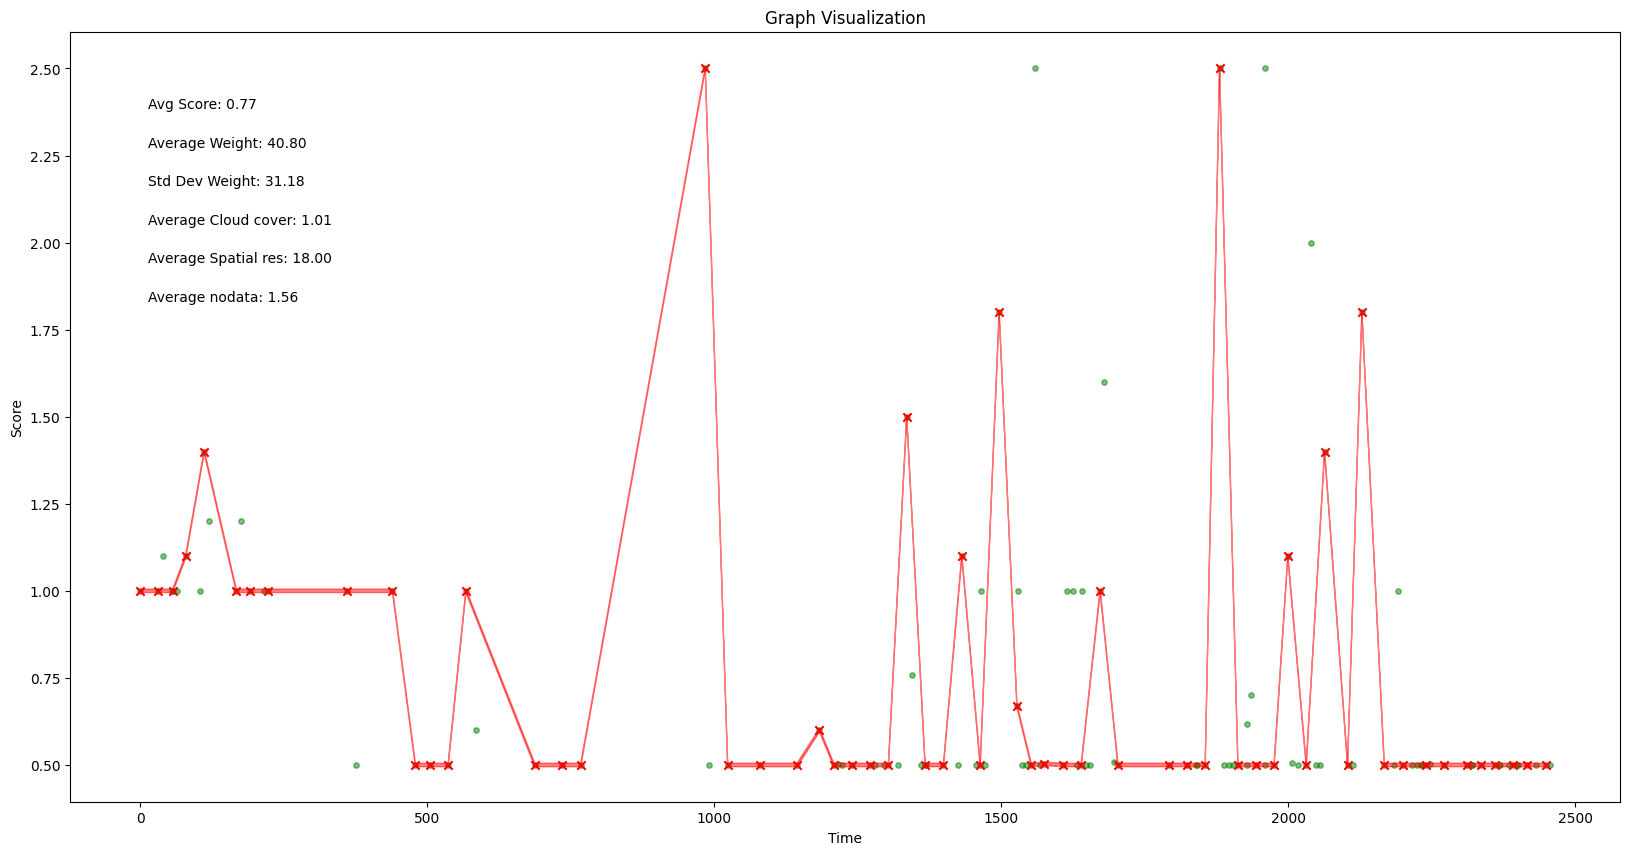

In [114]:
df = select_dates(df, target_weight=30, lower_bound=20, verbose=2, cc_ub=10, sr_ub=30, nd_ub=25)

In [115]:
df.selected.sum()

61.0

In [117]:
df[ df.selected == 1].index.tolist()

[0,
 1,
 4,
 6,
 8,
 10,
 12,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 35,
 36,
 39,
 41,
 44,
 46,
 48,
 50,
 53,
 54,
 58,
 61,
 62,
 66,
 70,
 73,
 74,
 75,
 78,
 79,
 83,
 87,
 90,
 91,
 94,
 98,
 99,
 101,
 102,
 105,
 110,
 112,
 113,
 116,
 117,
 121,
 124,
 126]